In [1]:
# Librerías de siempre
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import datetime
from time import time
import statsmodels.api as sm
import itertools
from random import shuffle
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col
from scipy import stats
from scipy.stats import chi2

In [11]:
def significancia_variables(mod,var,replace_spaces = True, std_err = True, stars = True):
    coef = "%.3f" % (np.round(mod.params[var], decimals = 3))
    se = "%.3f" % (np.round(mod.bse[var], decimals = 3))
    if mod.params[var] > 0:
        output = '~' + str(coef)                 
    else:
        output = str(coef)
    if std_err:
        output = output + ' (' + str(se) + ')'
    if stars:
        pval = np.round(mod.pvalues[var], 3)
        if pval < 0.01:
            output = output + '***'
        elif pval < 0.05 and pval >= 0.01:
            output = output + '**~'
        elif pval < 0.1 and pval >=0.05:
            output = output + '*~~'
        else:
            output = output + '~~~'
    if replace_spaces:
        output = output.replace("~"," ")
    return output

In [2]:
def ArmarDatosRegAsistencia(datadir, regdir, liga):
    arch_liga = liga + '.xlsx'
    df = pd.read_excel(os.path.join(datadir,arch_liga))
    df_reg = pd.read_excel(os.path.join(regdir,arch_liga))
    df = df[['Torneo','Round','Local','Visita','Attendance','Capacity']]
    cols_categoria = [i for i in df_reg.columns if 'categoria' in i]
    df_reg = df_reg[['equipo','Torneo'] + cols_categoria]
    for col in cols_categoria:
        df_reg[col] = df_reg[col].astype('category')
        df_reg[col].cat.reorder_categories(['regular', 'facil','dificil'], inplace = True)
    df_reg_l = df_reg[[i for i in df_reg.columns if 'visita' not in i]]
    df_reg_l = df_reg_l[['Torneo','equipo'] + [i for i in df_reg_l if i not in ['equipo','Torneo']]]
    df_reg_l.columns = ['Torneo','Local'] + [i + '_l' for i in df_reg_l if i not in ['equipo','Torneo']]
    df_reg_v = df_reg[[i for i in df_reg.columns if 'local' not in i]]
    df_reg_v = df_reg_v[['Torneo','equipo'] + [i for i in df_reg_v if i not in ['equipo','Torneo']]]
    df_reg_v.columns = ['Torneo','Visita'] + [i + '_v' for i in df_reg_v if i not in ['equipo','Torneo']]
    df_reg_att = df.merge(df_reg_l,
                        how = 'left',
                        left_on = ['Torneo','Local'],
                        right_on = ['Torneo','Local'])
    df_reg_att = df_reg_att.merge(df_reg_v,
                        how = 'left',
                        left_on = ['Torneo','Visita'],
                        right_on = ['Torneo','Visita'])
    df_reg_att['Ocupation'] = np.minimum(df_reg_att['Attendance']/df_reg_att['Capacity'], 1)
    df_reg_att = df_reg_att[['Torneo','Round','Local','Visita','Ocupation'] + [i for i in df_reg_att.columns if 'categoria' in i]]
    df_reg_att_b = df_reg_att[['Torneo','Round','Local','Visita','Ocupation']]
    df_reg_att_c = pd.get_dummies(df_reg_att[[i for i in df_reg_att.columns if i not in ['Torneo','Round','Local','Visita','Ocupation']]],
                                  drop_first = True)
    df_reg_att_a = pd.concat([df_reg_att_b,df_reg_att_c], axis = 1)
    torneos = df_reg_att_a['Torneo'].drop_duplicates().tolist()
    df_reg_att_a = df_reg_att_a[~(df_reg_att_a['Torneo'] == torneos[0])]
    return df_reg_att_a.dropna().reset_index(drop=True)

In [22]:
datadir = os.path.join(os.path.pardir,'Datos','Ligas')
regdir = os.path.join(os.path.pardir,'Datos','Bases construidas','Bases main','Bases efecto')
liga = 'Inglaterra'
df_reg = pd.read_excel(os.path.join(regdir, liga + '.xlsx'))
df_att = ArmarDatosRegAsistencia(datadir, regdir, liga)

In [23]:
df_reg.head()

,equipo,position,Torneo,perc_facil_general_p4_c3,perc_dificil_general_p4_c3,perc_regular_general_p4_c3,perc_facil_lv_p4_c3,perc_dificil_lv_p4_c3,perc_regular_lv_p4_c3,facil_general_corr,...,ratio_lv_p4,n_local_p5,n_visita_p5,ratio_lv_p5,n_local_p6,n_visita_p6,ratio_lv_p6,n_local_p7,n_visita_p7,ratio_lv_p7
0,Manchester United,1,Premier League 1993/1994,0.25,0.50,0.25,0.25,0.25,0.50,1.0,...,1.0,2,3,0.666667,3,3,1.0,3,4,0.750000
1,Blackburn Rovers,2,Premier League 1993/1994,0.25,0.25,0.50,0.25,0.00,0.75,1.0,...,1.0,2,3,0.666667,3,3,1.0,3,4,0.750000
2,Newcastle United,3,Premier League 1993/1994,0.00,0.25,0.75,0.25,0.25,0.50,0.0,...,1.0,3,2,1.500000,3,3,1.0,4,3,1.333333
3,Arsenal FC,4,Premier League 1993/1994,0.00,0.00,1.00,0.25,0.00,0.75,0.0,...,1.0,3,2,1.500000,3,3,1.0,4,3,1.333333
4,Leeds United,5,Premier League 1993/1994,0.25,0.25,0.50,0.25,0.00,0.75,1.0,...,1.0,2,3,0.666667,3,3,1.0,3,4,0.750000


In [30]:
def FiltrarNumeroPartidos(df_reg_att, r):
#     cols = ['Ocupation'] + [i for i in df_reg_att.columns if 'categoria' in i]
#     ops = ['mean' for i in range(len(cols))]
#     dictagg = dict(zip(cols,ops))
    df_reg_att_pr = df_reg_att[df_reg_att['Round'] <= r][['Local','Torneo','Ocupation']].reset_index(drop=True)
    df_reg_att_nr = df_reg_att[(df_reg_att['Round'] >= r + 1) &
                               (df_reg_att['Round'] <= 2*r)][['Local','Torneo','Ocupation']].reset_index(drop=True)
    df_reg_att_nr = df_reg_att_nr.groupby(['Local','Torneo']).agg({'Ocupation': 'mean'})
    df_reg_att_nr.rename(columns={'Ocupation': 'Ocupation_2'}, inplace = True)
    df_reg_att_fin = df_reg_att_pr.groupby(['Local','Torneo']).agg({'Ocupation': 'mean'})
    df_reg_att_fin.rename(columns={'Ocupation': 'Ocupation_1'}, inplace = True)
    df_reg_att_fin = df_reg_att_fin.merge(df_reg_att_nr,
                                          how = 'left',
                                          left_index = True,
                                          right_index = True).reset_index()
    df_reg_att_fin['Var_p%s' % r] = (df_reg_att_fin['Ocupation_2'] - df_reg_att_fin['Ocupation_1'])/df_reg_att_fin['Ocupation_1']
    df_reg_att_fin = df_reg_att_fin.drop(['Ocupation_1','Ocupation_2'], axis = 1).replace([np.inf, -np.inf], np.nan).dropna()
    df_reg_att_fin.columns = ['equipo','Torneo','Var_p%s' % r]
    return df_reg_att_fin

In [31]:
def AgregarVariacionAsistencia(df_reg, df_att):
    for r in [4,5,6,7]:
        df_reg_att = FiltrarNumeroPartidos(df_att,r)
        df_reg = df_reg.merge(df_reg_att, left_on = ['Torneo','equipo'], right_on = ['Torneo','equipo'])
    return df_reg

In [32]:
df_reg = AgregarVariacionAsistencia(df_reg, df_att)

In [34]:
df_reg.to_excel(os.path.join(regdir, 'Inglaterra.xlsx'), index = False)

In [4]:
def ResumenRegresion1Var(df_reg, variables, y = 'Var'):
    formulas = [y + ' ~ %s',
                y + ' ~ %s + Local',
                y + ' ~ %s + Torneo',
                y + ' ~ %s + Local + Torneo']
    models = []
    variable = '+'.join(variables)
    for formula in formulas:
        formula_ = formula % variable
        mod = ols(formula = formula_, data = df_reg).fit(cov_type = 'cluster',
                                                         cov_kwds={'groups': df_reg['Local']})
        models.append(mod)
    regressors = ['Intercept'] + variables
    tble = summary_col(models,
                       regressor_order = regressors,
                       drop_omitted=True,
                       stars = True,
                       float_format = '%0.3f',
                       model_names = ['Base','EF Equipo','EF Torneo', 'EFs Equipo y Torneo'],
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared),
                                  'R2a': lambda x: "{:.2f}".format(x.rsquared_adj),
                                  'LL': lambda x: "{:.2f}".format(x.llf)})
#     tble.tables[0] = tble.tables[0].loc[regressors]
    return tble.tables[0]

In [9]:
def ConstructorTablaCoeficientes1VarLR(df_att, variable):
    rl = []
    columnas = ['Base','EF Equipo', 'EF Torneo', 'EF Equipo y Torneo']
    df_coef = pd.DataFrame(data = np.zeros((12,4)), columns = columnas)
    coefs = [[] for i in range(4)]
    for r in [4,5,6,7]:
        df_reg = FiltrarNumeroPartidos(df_att,r)
        for l in [3,4,5]:
            formulas = ['Var ~ categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
                        'Var ~ Local + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
                        'Var~ Torneo + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
                        'Var ~ Local + Torneo + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s']
            var = variable % l
            rl.append("$r = %s, l = %s$" % (r,l))
            for i in range(len(formulas)):
                formula_ = formulas[i] % (l,l,var)
                mod = ols(formula = formula_, data = df_reg).fit(cov_type = 'cluster',
                                                                 cov_kwds={'groups': df_reg['Local']})
                coefs[i].append(significancia_variables(mod,var, replace_spaces=False, std_err=True, stars = False))
    for i in range(4):
        df_coef[columnas[i]] = coefs[i]
    df_coef['rl'] = rl
    df_coef.set_index('rl', inplace = True)
    return df_coef

In [15]:
## Ejecución
datadir = os.path.join(os.path.pardir,'Datos','Ligas')
regdir = os.path.join(os.path.pardir,'Datos','Bases construidas','Bases main','Bases efecto')
liga = 'Inglaterra'
df_att = ArmarDatosRegAsistencia(datadir, regdir, liga)
# variables = ['categoria_general_c%s_l_facil',
#              'categoria_general_c%s_l_dificil',
#              'categoria_general_c%s_v_facil']
# variables = ['categoria_general_c%s_l_facil',
#              'categoria_general_c%s_l_dificil',
#              ]
print(ConstructorTablaCoeficientes1VarLR(df_att, 'categoria_general_c%s_v_dificil').to_latex())

\begin{tabular}{lllll}
\toprule
{} &            Base &       EF Equipo &       EF Torneo & EF Equipo y Torneo \\
rl             &                 &                 &                 &                    \\
\midrule
\$r = 4, l = 3\$ &  -0.082 (0.025) &  -0.084 (0.027) &  -0.081 (0.025) &     -0.083 (0.027) \\
\$r = 4, l = 4\$ &  -0.073 (0.028) &  -0.076 (0.031) &  -0.072 (0.027) &     -0.075 (0.030) \\
\$r = 4, l = 5\$ &  -0.071 (0.028) &  -0.074 (0.032) &  -0.071 (0.028) &     -0.073 (0.032) \\
\$r = 5, l = 3\$ &  -0.064 (0.017) &  -0.064 (0.019) &  -0.061 (0.018) &     -0.061 (0.019) \\
\$r = 5, l = 4\$ &  -0.063 (0.019) &  -0.060 (0.022) &  -0.060 (0.019) &     -0.057 (0.021) \\
\$r = 5, l = 5\$ &  -0.055 (0.022) &  -0.055 (0.025) &  -0.052 (0.021) &     -0.051 (0.025) \\
\$r = 6, l = 3\$ &  -0.053 (0.013) &  -0.051 (0.015) &  -0.053 (0.014) &     -0.052 (0.017) \\
\$r = 6, l = 4\$ &  -0.062 (0.017) &  -0.058 (0.018) &  -0.062 (0.016) &     -0.058 (0.018) \\
\$r = 6, l = 5\$ &  -0.05

In [9]:
print(out_test.to_latex())

\begin{tabular}{lllll}
\toprule
{} &       Base &  EF Equipo &  EF Torneo & EFs Equipo y Torneo \\
\midrule
Intercept                      &   0.025*** &   0.021*** &      0.044 &               0.043 \\
                               &    (0.006) &    (0.006) &    (0.030) &             (0.031) \\
categoria\_general\_c4\_l\_facil   &     -0.008 &    -0.012* &     -0.008 &              -0.011 \\
                               &    (0.006) &    (0.007) &    (0.006) &             (0.007) \\
categoria\_general\_c4\_l\_dificil &    -0.010* &     -0.009 &     -0.010 &              -0.007 \\
                               &    (0.006) &    (0.008) &    (0.006) &             (0.008) \\
categoria\_general\_c4\_v\_dificil &  -0.062*** &  -0.058*** &  -0.062*** &           -0.058*** \\
                               &    (0.017) &    (0.018) &    (0.016) &             (0.018) \\
N                              &        504 &        504 &        504 &                 504 \\
R2                       

In [5]:
def ConstructorCoeficientes1VarLR(df_att, variable, formula, conf):
    rl = []
    coefs = []
    lb = []
    ub = []
    for r in [4,5,6,7]:
        df_reg = FiltrarNumeroPartidos(df_att,r)
        for l in [3,4,5]:
            var = variable % l
            rl.append("$r = %s, l = %s$" % (r,l))
            formula_ = formula % (l,l, var) 
            mod = ols(formula = formula_, data = df_reg).fit(cov_type = 'cluster',
                                                             cov_kwds={'groups': df_reg['Local']})
            coefs.append(mod.params[var])
            ci = mod.conf_int(alpha=conf)
            lb.append(ci.loc[var,0])
            ub.append(ci.loc[var,1])
    df_coef = pd.DataFrame(data = {'LB':lb, 'Beta' : coefs, 'UB':ub}, index = rl)
    return df_coef

In [6]:
def GraficoCoeficientes1VarLR(datadir, regdir, archivo, formulas, textformulas, variable, plotname, conf = 0.05):
    dictreplaces = {'categoria_general_c%s_v_facil': 'Frac. partidos fáciles',
                    'categoria_general_c%s_v_dificil': 'Frac. partidos difíciles'}
    cint = str(int((1-conf)*100)) + '%'
    title = dictreplaces[variable]
    title = '$x_{it}$: ' + title
    liga = archivo.replace('.xlsx','')
    df_att = ArmarDatosRegAsistencia(datadir, regdir, liga)
    fig, axs = plt.subplots(figsize=(5,10), nrows = len(formulas), sharex= True)
    plt.suptitle(title)
    for i in range(len(formulas)):
        formula = formulas[i]
        textformula = textformulas[i]
        ax = axs[i]
        df_coef = ConstructorCoeficientes1VarLR(df_att, variable, formula, conf)
        x = df_coef.index.tolist()
        lb = df_coef.LB.tolist()
        ub = df_coef.UB.tolist()
        beta = df_coef.Beta.tolist()
        ax.plot(x, beta, color = 'g' ,label='Beta')
        ax.fill_between(x, lb, ub, color='grey', label='I.C. %s' %cint)
#         ax.plot(df_coef.index.tolist(), ,linestyle = ':', color = 'r' ,label='LB %s' % cint)
#         ax.plot(df_coef.index.tolist(), df_coef.UB.tolist(),linestyle = ':', color = 'b' ,label='UB %s' % cint)
        ax.axhline(y=0, color='k')
        ax.set_ylabel(r'$\beta$')
        ax.legend()
        ax.set_title(textformula)
        if i == len(formulas) - 1:
            ax.set_xlabel('Valores de $r$ y $l$')
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)
    plt.xticks(rotation=90)
    fig.savefig(os.path.join(os.path.pardir,'Graficos','%s.png' % plotname), bbox_inches = "tight", dpi = 250)

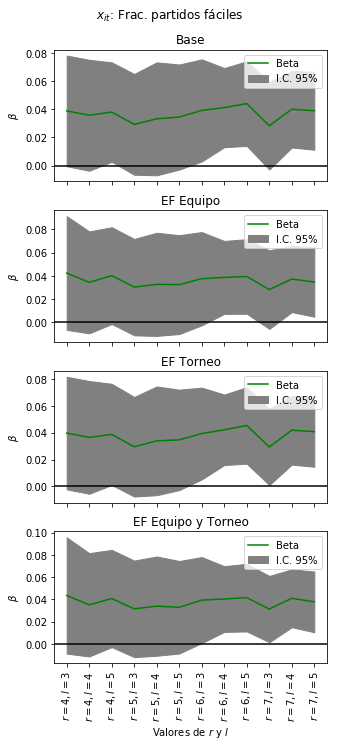

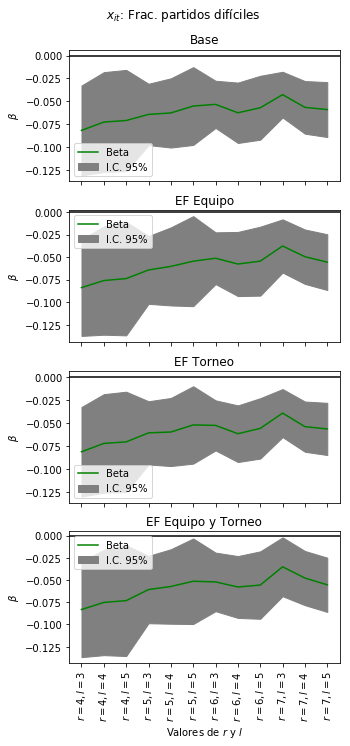

In [20]:
## EJECUCION
datadir = os.path.join(os.path.pardir,'Datos','Ligas')
regdir = os.path.join(os.path.pardir,'Datos','Bases construidas','Bases main','Bases efecto')
archivo = 'Inglaterra.xlsx'
formulas = ['Var ~ categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
            'Var ~ Local + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
            'Var~ Torneo + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s',
            'Var ~ Local + Torneo + categoria_general_c%s_l_facil + categoria_general_c%s_l_dificil + %s']
textformulas = ['Base','EF Equipo', 'EF Torneo', 'EF Equipo y Torneo']
variables = ['categoria_general_c%s_v_facil',
             'categoria_general_c%s_v_dificil']
plotnames = ['fracfaciles1varatting','fracdificiles1varatting']
for i in range(len(variables)):
    variable = variables[i]
    plotname = plotnames[i]
    GraficoCoeficientes1VarLR(datadir, regdir, archivo, formulas, textformulas, variable, plotname, conf = 0.05)

In [8]:
def ResumenRegresion1VarHet(df_reg, variables, y = 'Var'):
    formulas = [y + ' ~ %s',
                y + ' ~ %s + Local',
                y + ' ~ %s + Torneo',
                y + ' ~ %s + Local + Torneo']
    variable = variables[2] + '*' + variables[0] + ' + ' + variables[2] + '*' + variables[1]
    models = []
    for formula in formulas:
        formula_ = formula % variable
        mod = ols(formula = formula_, data = df_reg).fit(cov_type = 'cluster',
                                                         cov_kwds={'groups': df_reg['Local']})
        models.append(mod)
    regressors = ['Intercept',
                  variables[2],
                  variables[0],
                  variables[1], 
                  variables[2] + ':' + variables[0],
                  variables[2] + ':' + variables[1]]
    tble = summary_col(models,
                       regressor_order = regressors,
                       drop_omitted=True,
                       stars = True,
                       float_format = '%0.3f',
                       model_names = ['Base','EF Equipo','EF Torneo', 'EFs Equipo y Torneo'],
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:.2f}".format(x.rsquared),
                                  'R2a': lambda x: "{:.2f}".format(x.rsquared_adj),
                                  'LL': lambda x: "{:.2f}".format(x.llf)})
#     tble.tables[0] = tble.tables[0].loc[regressors]
    return tble.tables[0]

In [9]:
## Ejecución
datadir = os.path.join(os.path.pardir,'Datos','Ligas')
regdir = os.path.join(os.path.pardir,'Datos','Bases construidas','Bases main','Bases efecto')
liga = 'Inglaterra'
df_reg = FiltrarNumeroPartidos(ArmarDatosRegAsistencia(datadir, regdir, liga),6)
variables = ['categoria_general_c%s_l_facil',
             'categoria_general_c%s_l_dificil',
             'categoria_general_c%s_v_facil']
# variables = ['categoria_general_c%s_l_facil',
#              'categoria_general_c%s_l_dificil',
#              'categoria_general_c%s_v_dificil']
out_test = ResumenRegresion1VarHet(df_reg, [i % 4 for i in variables], y = 'Var')

In [10]:
print(out_test.to_latex())

\begin{tabular}{lllll}
\toprule
{} &     Base & EF Equipo & EF Torneo & EFs Equipo y Torneo \\
\midrule
Intercept                                          &   -0.005 &    -0.012 &     0.017 &               0.011 \\
                                                   &  (0.009) &   (0.012) &   (0.030) &             (0.031) \\
categoria\_general\_c4\_v\_facil                       &  0.056** &    0.056* &   0.052** &             0.053** \\
                                                   &  (0.026) &   (0.029) &   (0.023) &             (0.027) \\
categoria\_general\_c4\_l\_facil                       &    0.006 &     0.003 &     0.004 &               0.002 \\
                                                   &  (0.011) &   (0.011) &   (0.010) &             (0.011) \\
categoria\_general\_c4\_l\_dificil                     &    0.000 &     0.003 &    -0.002 &               0.000 \\
                                                   &  (0.010) &   (0.010) &   (0.010) &             (0.010)

In [7]:
def ConstructorCoeficientes1VarHetLR(df_att, variables, formula, conf = 0.05):
    rl = []
    # Lista de listas: 5 listas con 3 entradas cada una.
    # Orden de la primera entrada: x, F, D, x*F, x*D
    # Orden de la segunda entrada: beta, lb, ub
    results = [[[], [], []] for i in range(2)]
    for r in [4,5,6,7]:
        df_reg = FiltrarNumeroPartidos(df_att,r)
        for l in [3,4,5]:
            variables_ = [v % l for v in variables]
            variable = variables_[2] + '*' + variables_[0] + ' + ' + variables_[2] + '*' + variables_[1]
            rl.append("$r = %s, l = %s$" % (r,l))
            entradas = [variables_[2] + ':' + variables_[0],
                        variables_[2] + ':' + variables_[1]]
            formula_ = formula % variable
            mod = ols(formula = formula_, data = df_reg).fit(cov_type = 'cluster',
                                                             cov_kwds={'groups': df_reg['Local']})
            ci = mod.conf_int(alpha=conf)
            for i in range(2):
                ent = entradas[i]
                results[i][0].append(mod.params[ent])
                results[i][1].append(ci.loc[ent,0])
                results[i][2].append(ci.loc[ent,1])
    dfs = []
    variables = ['xF','xD']
    for i in range(2):
        col = variables[i]
        data = results[i]
        df = pd.DataFrame({col: data[0], col + '_lb': data[1], col + '_ub': data[2]}, index = rl)
        dfs.append(df)
    df_coef = pd.concat(dfs, axis = 1)
    return df_coef

In [48]:
def GraficoCoeficientes1VarHetLR(datadir,
                                 regdir,
                                 archivo,
                                 formulas,
                                 textformulas,
                                 variables,
                                 inters,
                                 plotname,
                                 conf = 0.05):
    dictreplaces = {'categoria_general_c%s_v_facil': 'Frac. partidos fáciles',
                    'categoria_general_c%s_v_dificil': 'Frac. partidos difíciles'}
    cint = str(int((1-conf)*100)) + '%'
    title = dictreplaces[variables[2]]
    title = '$x_{it}$: ' + title
    liga = archivo.replace('.xlsx','')
    dictvariables = {'x': '$x_{it}$',
                     'F' : '$F_{it}$',
                     'D': '$D_{it}$',
                     'xF':'$x_{it}F_{it}$',
                     'xD':'$x_{it}D_{it}$'}
    df_att = ArmarDatosRegAsistencia(datadir, regdir, liga)
    for word, replace in dictreplaces.items():
        title = title.replace(word, replace)
    df_reg = pd.read_excel(os.path.join(datadir, archivo))
    dfs_coef = []
    for i in range(len(formulas)):
        formula = formulas[i]
        dfs_coef.append(ConstructorCoeficientes1VarHetLR(df_att, variables, formula, conf))


    for inter in inters:
        fig, axs = plt.subplots(figsize=(5,10), nrows = len(formulas), sharex= True)
        plt.suptitle(title + ' - ' + dictvariables[inter])
        for i in range(len(formulas)):
            df_coef = dfs_coef[i]
            formula = formulas[i]
            textformula = textformulas[i]
            ax = axs[i]
            x = df_coef.index.tolist()
            lb = df_coef[inter + '_lb'].tolist()
            ub = df_coef[inter + '_ub'].tolist()
            beta = df_coef[inter].tolist()
            ax.plot(x, beta, color = 'g' ,label='Beta')
            ax.fill_between(x, lb, ub, color='grey', label='I.C. %s' %cint)
    #         ax.plot(df_coef.index.tolist(), ,linestyle = ':', color = 'r' ,label='LB %s' % cint)
#         ax.plot(df_coef.index.tolist(), df_coef.UB.tolist(),linestyle = ':', color = 'b' ,label='UB %s' % cint)
            ax.axhline(y=0, color='k')
            ax.set_ylabel(r'$\beta$')
            ax.legend()
            ax.set_title(textformula)
            if i == len(formulas) - 1:
                ax.set_xlabel('Valores de $r$ y $l$')
#             fig.tight_layout()
            fig.subplots_adjust(top=0.92)
            plt.xticks(rotation=90)
            plotname_ = plotname + inter
            fig.savefig(os.path.join(os.path.pardir,'Graficos','%s.png' % plotname_), bbox_inches = "tight", dpi = 250)

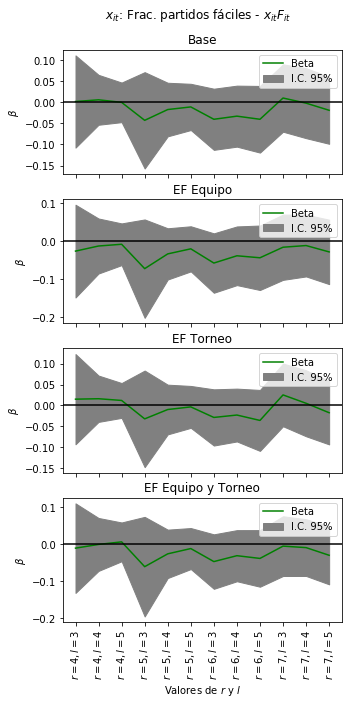

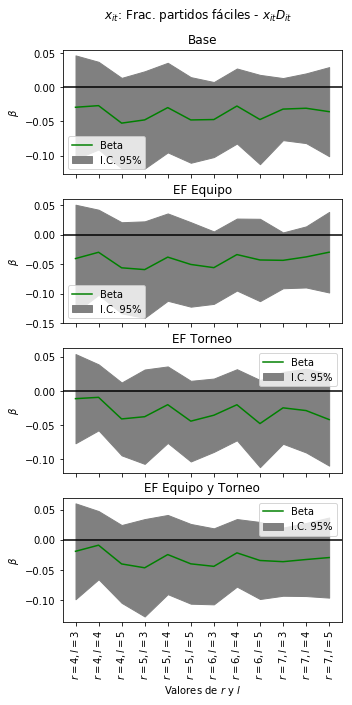

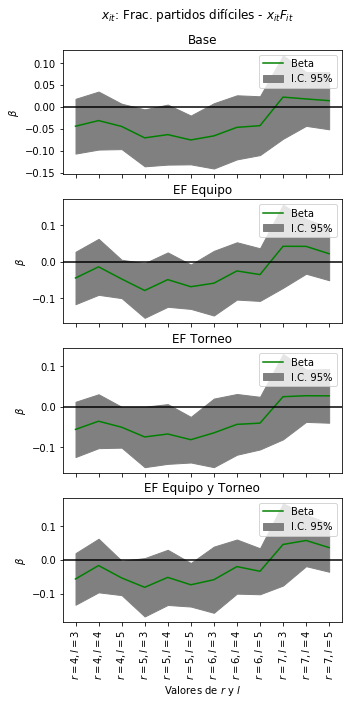

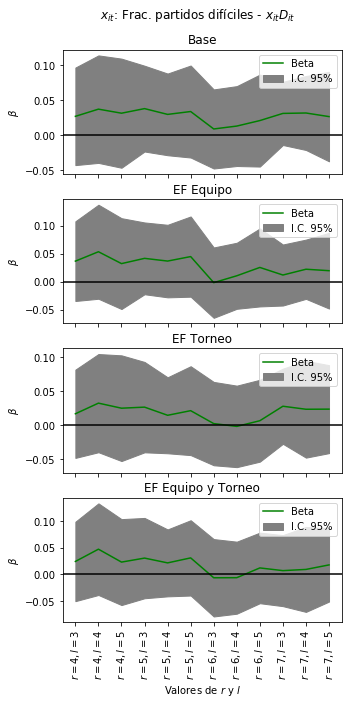

In [54]:
## EJECUCION
datadir = os.path.join(os.path.pardir,'Datos','Ligas')
regdir = os.path.join(os.path.pardir,'Datos','Bases construidas','Bases main','Bases efecto')
liga = 'Inglaterra'
df_reg = FiltrarNumeroPartidos(ArmarDatosRegAsistencia(datadir, regdir, liga),6)
# variables = ['categoria_general_c%s_l_facil',
#              'categoria_general_c%s_l_dificil',
#              'categoria_general_c%s_v_facil']
formulas = ['Var ~ %s',
            'Var ~ %s + Local',
            'Var ~ %s + Torneo',
            'Var ~ %s + Local + Torneo']
variables_ = [['categoria_general_c%s_l_facil',
               'categoria_general_c%s_l_dificil',
               'categoria_general_c%s_v_facil'],
              ['categoria_general_c%s_l_facil',
               'categoria_general_c%s_l_dificil',
               'categoria_general_c%s_v_dificil']]
inters = ['xF', 'xD']
plotnames = ['fracfaciles1varhetatting','fracdificiles1varhetatting']
for i in range(len(variables_)):
    variables = variables_[i]
    plotname = plotnames[i]
    GraficoCoeficientes1VarHetLR(datadir, regdir, archivo, formulas, textformulas, variables, inters, plotname, conf = 0.05)